In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

calib = np.load('phonecam_calib.npz')
K = calib['mtx']
dist = calib['dist']

Without knowing the relative pose of the cameras that took our stereo image pair, let's just use some point correspondences to estimate the fundamental and essential matrices, and then rectify the images.

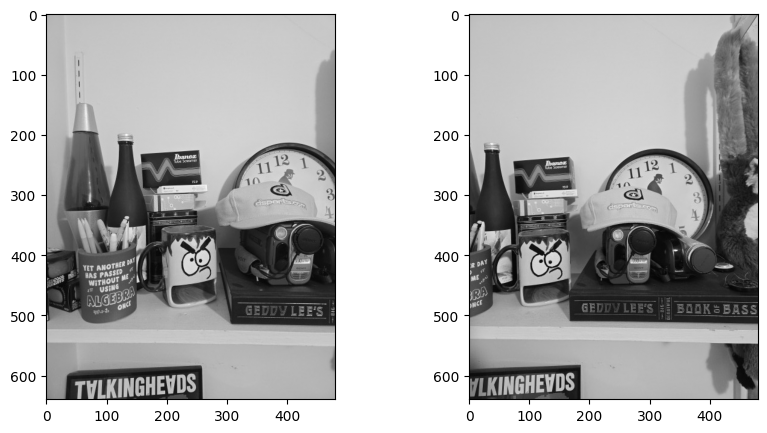

In [35]:
idx = '01'
imgl = cv.imread(f"left{idx}.jpg")
imgl = cv.cvtColor(imgl, cv.COLOR_BGR2GRAY)

imgr = cv.imread(f"right{idx}.jpg")
imgr = cv.cvtColor(imgr, cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(imgl, 'gray')
ax[1].imshow(imgr, 'gray')
plt.show()

Found 106 matches.


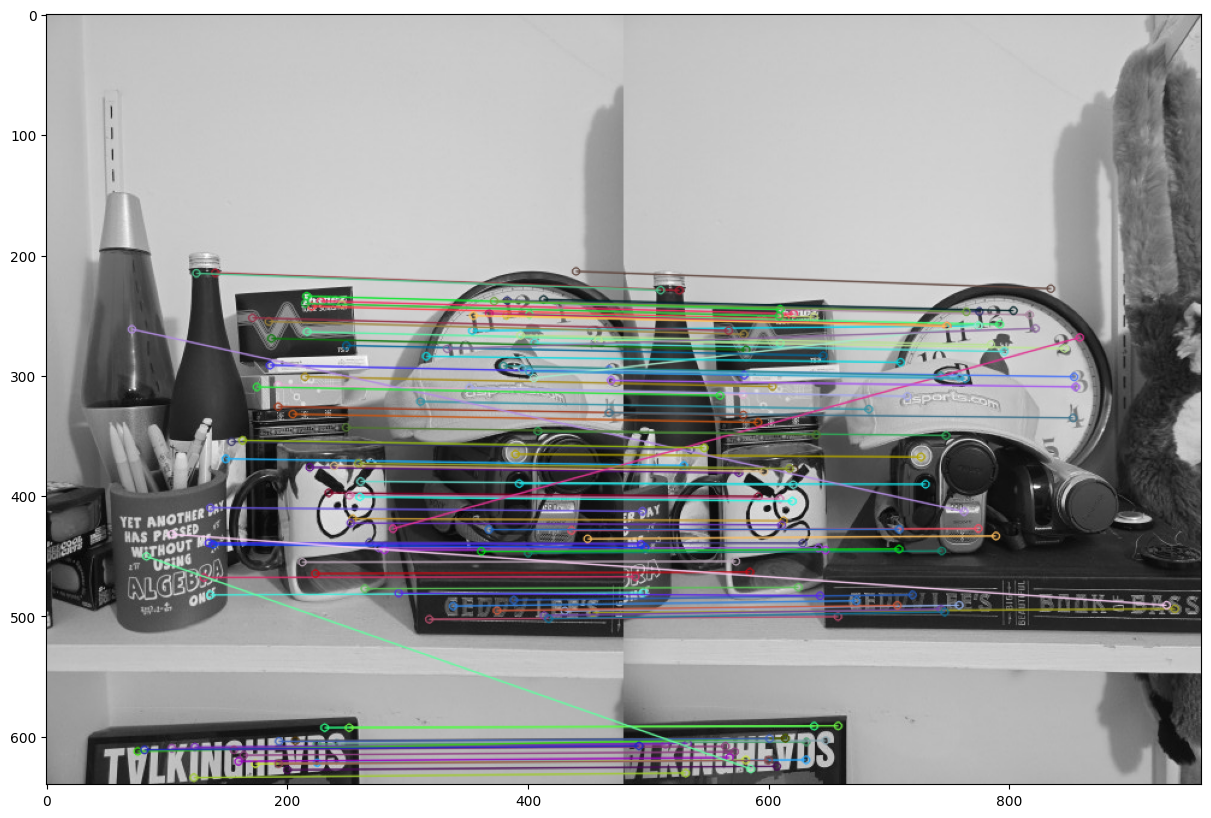

In [36]:
def spatial_nms(kp, matches, grid_size=20):
    """Perform simple non-maximal suppression on the matches.
    This prevents us from getting multiple matches representing
    very close pixel areas.
    """
    used_cells = set()
    filtered_matches = []

    for m in sorted(matches, key=lambda x: x.distance):
        x, y = map(int, kp[m.queryIdx].pt)
        cell = (x // grid_size, y // grid_size)
        if cell not in used_cells:
            filtered_matches.append(m)
            used_cells.add(cell)
    return filtered_matches

# Detect SIFT features
sift = cv.SIFT_create()
kp_l, desc_l = sift.detectAndCompute(imgl, None)
kp_r, desc_r = sift.detectAndCompute(imgr, None)

# Do FLANN matching
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_l, desc_r, k=2)

pts_l, pts_r = list(), list()
# Filter via Lowe's ratio test to remove unreliable (poor) matches
thresh = 0.7
good_matches = [m for (m,n) in matches if m.distance < thresh * n.distance]

# Filter via spatial NMS on good matches to remove redudant matches
filtered_matches = spatial_nms(kp_l, good_matches, grid_size=20)

# Extract points from the filtered matches
pts_l = np.float32([kp_l[m.queryIdx].pt for m in filtered_matches])
pts_r = np.float32([kp_r[m.trainIdx].pt for m in filtered_matches])

# Quickly view the matches
print(f"Found {len(filtered_matches)} matches.")
img_matches = cv.drawMatches(
    imgl, kp_l, imgr, kp_r, filtered_matches, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

fig = plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.show()

In [37]:
F, mask = cv.findFundamentalMat(
    points1=pts_l,
    points2=pts_r,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.99,
)

# Take the inliers
pts_l = pts_l[mask.ravel() == 1]
pts_r = pts_r[mask.ravel() == 1]

print(f"Filtered down to {len(pts_l)} inlier matches")

print("Fundamental matrix:")
print(F)

# E = K.T @ F @ K
E, mask = cv.findEssentialMat(
    pts_l,
    pts_r,
    K,
    method=cv.RANSAC,
    threshold=1.0,
    prob=0.999,
)

print("Essential matrix:")
print(E)

ret, E_ref, R, t, mask = cv.recoverPose(
    points1=pts_l.astype(np.float32),
    points2=pts_r.astype(np.float32),
    cameraMatrix1=K,
    cameraMatrix2=K,
    distCoeffs1=dist,
    distCoeffs2=dist,
    E=E,
)

print("Extrinsic rotation (R):")
print(R)

print("Extrinsic translation (t):")
print(t.flatten())

Filtered down to 77 inlier matches
Fundamental matrix:
[[-2.37562266e-07  2.23119434e-05 -6.07639305e-03]
 [-2.22730208e-05  6.54662739e-07 -6.35360182e-02]
 [ 5.65475011e-03  6.23468280e-02  1.00000000e+00]]
Essential matrix:
[[-0.00141985  0.17169607 -0.01479918]
 [-0.18431071  0.00684596 -0.68242194]
 [ 0.01240008  0.68583413  0.00775913]]
Extrinsic rotation (R):
[[ 0.99979835  0.01337343  0.01498067]
 [-0.01358126  0.99981173  0.01385838]
 [-0.01479252 -0.01405905  0.99979174]]
Extrinsic translation (t):
[-0.97971354  0.01434824  0.19988873]


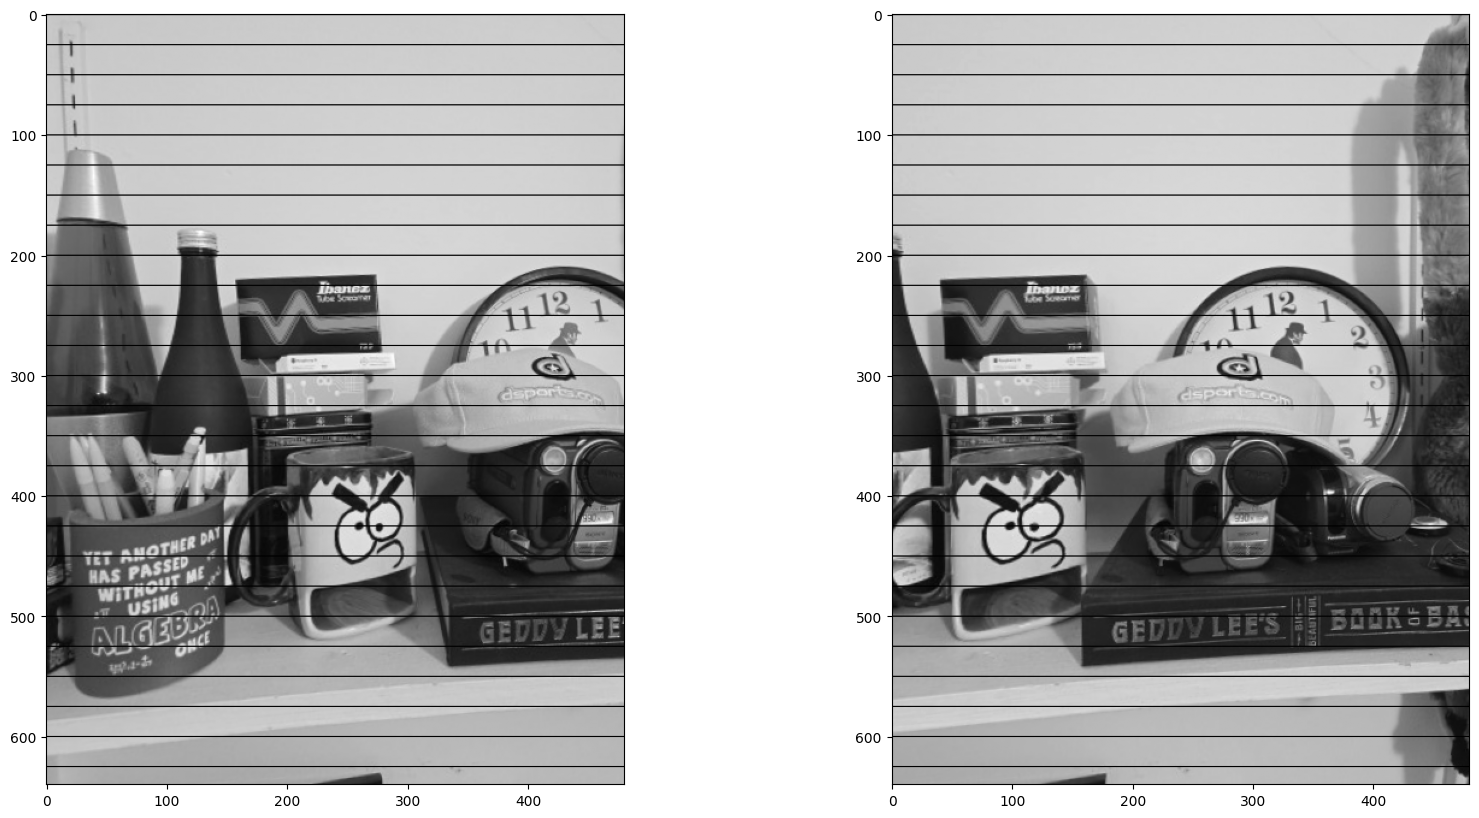

In [38]:
img_size = (imgl.shape[1], imgl.shape[0])

# Compute rectification transforms
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    K, dist,
    K, dist,
    img_size,
    R, t,
    flags=cv.CALIB_ZERO_DISPARITY,
    alpha=0,    # 0 = zoomed in,  1 = keep all pixels 
)

# Compute undistort and rectify maps
left_map1, left_map2 = cv.initUndistortRectifyMap(
    K, dist, R1, P1, img_size, cv.CV_16SC2
)
right_map1, right_map2 = cv.initUndistortRectifyMap(
    K, dist, R2, P2, img_size, cv.CV_16SC2
)

# Remap (warp) images
rect_l = cv.remap(imgl, left_map1, left_map2, interpolation=cv.INTER_LINEAR)
rect_r = cv.remap(imgr, right_map1, right_map2, interpolation=cv.INTER_LINEAR)


# Display the rectified image pair
def draw_lines(img, step=25):
    for y in range(0, img.shape[0], step):
        cv.line(img, (0, y), (img.shape[1], y), (0, 255, 0), 1)

draw_lines(rect_l)
draw_lines(rect_r)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(rect_l, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(rect_r, cmap='gray')

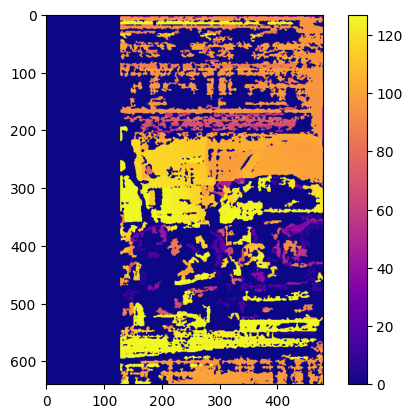

In [65]:
# Remap (warp) images again so that they are clean (no lines)
rect_l = cv.remap(imgl, left_map1, left_map2, interpolation=cv.INTER_LINEAR)
rect_r = cv.remap(imgr, right_map1, right_map2, interpolation=cv.INTER_LINEAR)

# Blur slightly?
sig = 1.0
rect_l = cv.GaussianBlur(rect_l, ksize=(5,5), sigmaX=sig)
rect_r = cv.GaussianBlur(rect_r, ksize=(5,5), sigmaX=sig)
# 
window_size = 5 # block size
num_disp = 128 # must be divisible by 16
stereo = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8 * 1 * window_size ** 2,
    P2=32 * 1 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=16,
    preFilterCap=31,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY,
)

# Compute the disparity map
disparity = stereo.compute(rect_l, rect_r).astype(np.float32) / 16.0

# Optional: mask invalid disparity values
disparity[disparity < 0] = 0

# Visualize
plt.imshow(disparity, 'plasma', vmin=disparity.min(), vmax=disparity.max())
plt.colorbar()
plt.show()

# Brighter colors (higher disparity) means moved farther

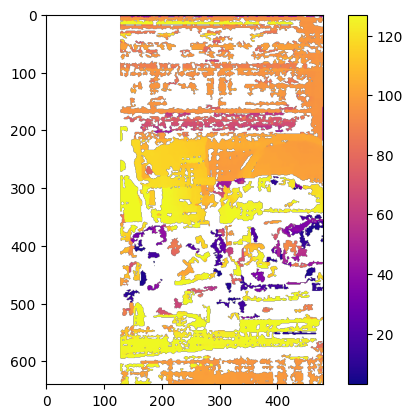

In [67]:
disp = disparity.copy()
disp[disp<3] = np.nan
plt.imshow(disp, cmap='plasma')
plt.colorbar()
plt.show()

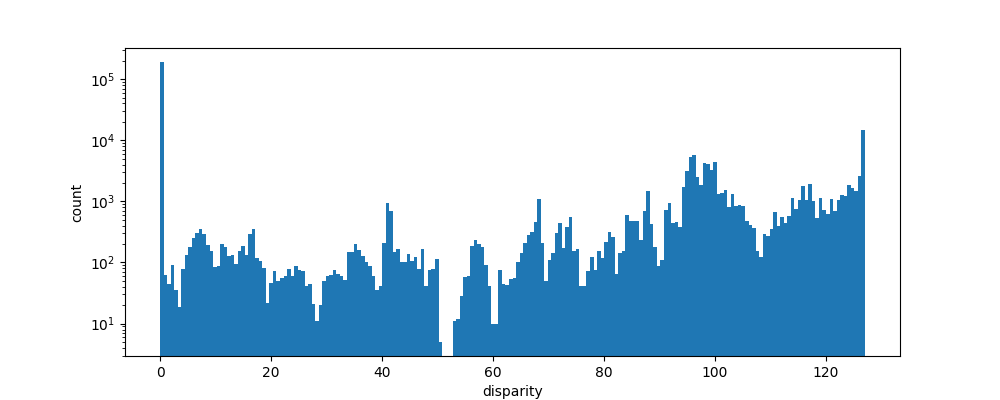

In [75]:
plt.figure(figsize=(10,4))
plt.hist(disparity.flatten(), bins=200)
plt.yscale("log")
plt.xlabel("disparity")
plt.ylabel("count")
plt.show()


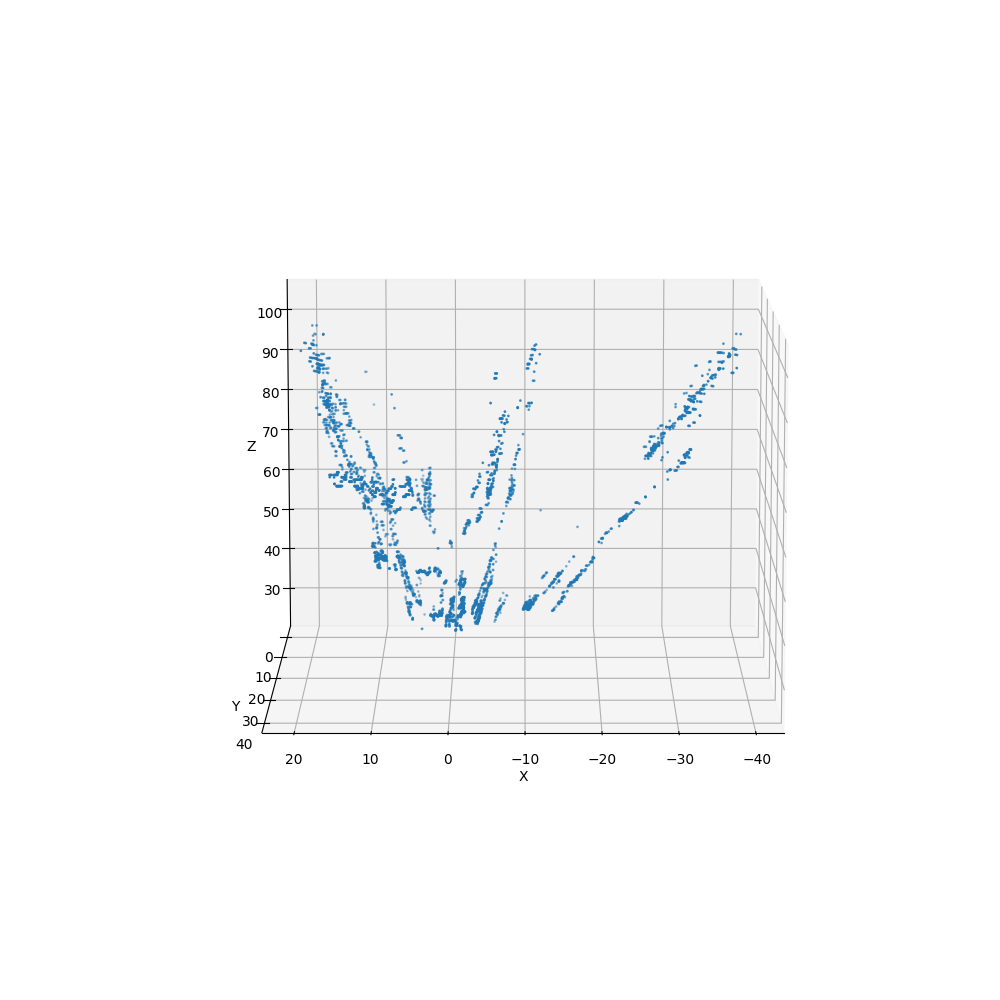

In [74]:
%matplotlib widget
points_3d = cv.reprojectImageTo3D(disparity=disparity, Q=Q)

# mask out the invalid points
mask = (disparity > 5.0) & (disparity < 20.0)
points = points_3d[mask]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.view_init(elev=10, azim=90)
plt.show()
